In [1]:
from pathlib import Path
import trimesh
import pandas as pd
import numpy as np

# --- 1) Paths ---
step_path = Path(r"C:\Users\abrik\Desktop\Work\Ballsnow\Code\Xiaomi\DPUB-501020596-XAX_03.002.stp")
glb_path  = Path("exports_actual_catias") / "DPUB-501020596-XAX_03.002.glb"   # adjust if different

# --- 2) Load weld points from STEP (only RSW) ---
def extract_rsw_points(step_file: Path, encoding: str = "latin-1") -> pd.DataFrame:
    import re
    with open(step_file, "r", encoding=encoding, errors="ignore") as f:
        text = f.read()

    pattern = re.compile(
        r"#\d+\s*=\s*CARTESIAN_POINT\('([^']*RSW[^']*)',\s*\(([^)]*)\)\s*\)\s*;",
        re.DOTALL,
    )

    rows = []
    for name, coords_str in pattern.findall(text):
        parts = [p for p in re.split(r"[,\s]+", coords_str.strip()) if p]
        try:
            coords = [float(p) for p in parts]
        except ValueError:
            continue
        if len(coords) != 3:
            continue
        rows.append({"name": name, "x": coords[0], "y": coords[1], "z": coords[2]})

    return pd.DataFrame(rows)

weld_df = extract_rsw_points(step_path)
print("RSW weld points:", len(weld_df))
display(weld_df.head())


RSW weld points: 66


,name,x,y,z
0,T16A-0000001286-RSW-GSMPoint.427,3700.882639,218.260034,229.142181
1,T16A-0000001288-RSW-GSMPoint.433,3700.882639,-218.260034,229.142181
2,T16A-0000001298-RSW-GSMPoint.449,3707.882639,171.297429,230.142181
3,T16A-0000001300-RSW-GSMPoint.451,3707.882639,91.115654,230.142181
4,T16A-0000001301-RSW-GSMPoint.452,3707.882639,-91.115654,230.142181


In [2]:
# --- 3) Load body mesh from GLB ---
obj = trimesh.load(glb_path)

if isinstance(obj, trimesh.Scene):
    # concatenate all geometries into a single mesh
    mesh_body = trimesh.util.concatenate(tuple(obj.geometry.values()))
else:
    mesh_body = obj

print(mesh_body)
print("Vertices:", mesh_body.vertices.shape)
print("Faces:", mesh_body.faces.shape)


<trimesh.Trimesh(vertices.shape=(214580, 3), faces.shape=(240683, 3))>
Vertices: (214580, 3)
Faces: (240683, 3)


In [3]:
import pyvista as pv
import numpy as np
from pathlib import Path

# body mesh from previous step
body_vertices = np.asarray(mesh_body.vertices, dtype=float)
body_faces    = np.asarray(mesh_body.faces, dtype=int)

# build faces array for PyVista
n_faces = body_faces.shape[0]
faces_pv = np.hstack(
    (np.full((n_faces, 1), 3, dtype=np.int64), body_faces.astype(np.int64))
).ravel()

mesh_pv = pv.PolyData(body_vertices, faces_pv)

print(mesh_pv)
print("PyVista n_points:", mesh_pv.n_points)
print("PyVista n_cells:", mesh_pv.n_cells)  # <-- use n_cells, not n_faces

out_dir = Path("exports_pv")
out_dir.mkdir(exist_ok=True, parents=True)

def make_view(view_fn, filename, show_welds=False):
    p = pv.Plotter(off_screen=True, window_size=(1920, 1080))
    
    # ✅ either as a string:
    # p.set_background("white")
    # or as a tuple/list:
    p.set_background((0.9, 0.9, 0.9))

    # BODY
    p.add_mesh(
        mesh_pv,
        color=(0.25, 0.45, 0.7),
        smooth_shading=True,
        show_edges=True,
        edge_color="black",
        line_width=0.3,
        lighting=True,
    )

    # WELDS
    if show_welds:
        p.add_points(
            weld_points,
            color="red",
            render_points_as_spheres=True,
            point_size=11,
        )

    view_fn(p)
    p.reset_camera()
    p.camera.zoom(1.3)

    p.show(screenshot=str(out_dir / filename))
    p.close()
    print("Saved:", out_dir / filename)


PolyData (0x1b050313940)
  N Cells:    240683
  N Points:   214580
  N Strips:   0
  X Bounds:   -7.700e+00, 3.817e+03
  Y Bounds:   -7.989e+02, 6.991e+02
  Z Bounds:   -4.297e-01, 5.304e+02
  N Arrays:   0
PyVista n_points: 214580
PyVista n_cells: 240683


c:\Users\abrik\miniconda3\envs\ballsnow_reconstruct\lib\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


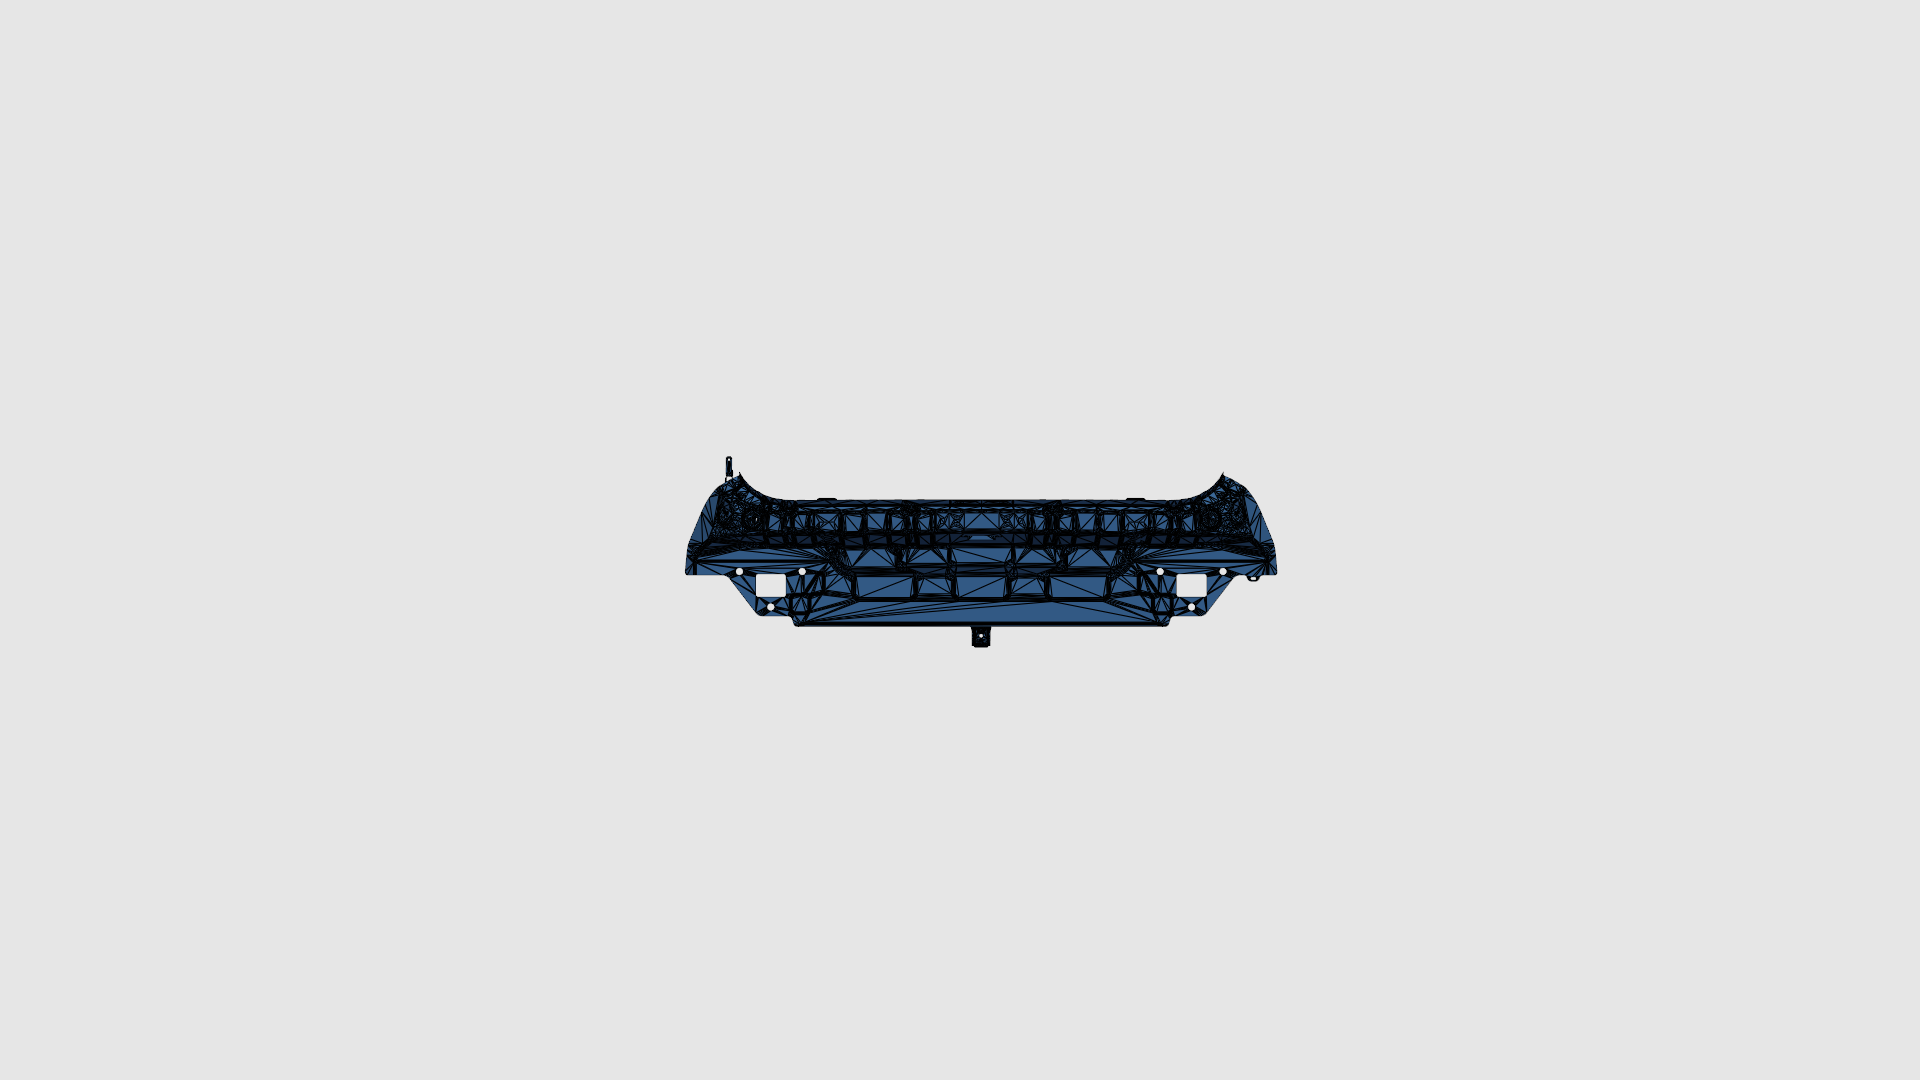

Saved: exports_pv\front_surface_welds.png


TypeError: 'float' object is not callable

In [4]:
# Front: look at the part from "outside" (tweak if flipped)
def view_front(p):
    p.view_yz()            # Y–Z plane
    # if it looks like rear, flip by 180°
    # p.camera.azimuth(180)

def view_rear(p):
    p.view_yz()
    p.camera.azimuth(180)  # opposite direction

def view_top(p):
    p.view_xy()            # look down -Z

def view_iso(p):
    p.view_isometric()

make_view(view_front, "front_surface_welds.png")
make_view(view_rear,  "rear_surface_welds.png")
make_view(view_top,   "top_surface_welds.png")
make_view(view_iso,   "iso_surface_welds.png")


In [5]:
import vtk
print(vtk.vtkVersion().GetVTKVersion())

9.5.2


In [6]:
import pyvista as pv
import numpy as np

# Wrap trimesh as PyVista PolyData
mesh_pv = pv.wrap(mesh_body).extract_surface()

# Weld points as PolyData
weld_xyz   = weld_df[["x", "y", "z"]].to_numpy()
weld_cloud = pv.PolyData(weld_xyz)

# --- Save to VTK formats ---

# 1) XML PolyData (modern VTK format, recommended)
mesh_pv.save("front_part_body.vtp")
weld_cloud.save("front_part_welds.vtp")

# 2) Legacy .vtk (if your old pipeline expects it)
mesh_pv.save("front_part_body.vtk")
weld_cloud.save("front_part_welds.vtk")

In [7]:
import vtk

# ---------- Readers ----------
body_reader = vtk.vtkXMLPolyDataReader()
body_reader.SetFileName("front_part_body.vtp")
body_reader.Update()
body_polydata = body_reader.GetOutput()

weld_reader = vtk.vtkXMLPolyDataReader()
weld_reader.SetFileName("front_part_welds.vtp")
weld_reader.Update()
weld_points = weld_reader.GetOutput()

In [8]:
print("== body_polydata geometry ==")
print("  points:", body_polydata.GetNumberOfPoints())
print("  cells :", body_polydata.GetNumberOfCells())
print("  polys :", body_polydata.GetNumberOfPolys())
print("  lines :", body_polydata.GetNumberOfLines())
print("  verts :", body_polydata.GetNumberOfVerts())

== body_polydata geometry ==
  points: 214580
  cells : 240683
  polys : 240683
  lines : 0
  verts : 0


In [12]:
import vtk

# ---- 1. Load body and welds ----
body_reader = vtk.vtkXMLPolyDataReader()
body_reader.SetFileName("front_part_body.vtp")   # <- your body vtp
body_reader.Update()
body_poly = body_reader.GetOutput()

print("body points:", body_poly.GetNumberOfPoints())
print("body polys :", body_poly.GetNumberOfPolys())

weld_reader = vtk.vtkXMLPolyDataReader()
weld_reader.SetFileName("front_part_welds.vtp")  # <- your weld vtp
weld_reader.Update()
weld_poly = weld_reader.GetOutput()
print("weld points:", weld_poly.GetNumberOfPoints())

# ---- 2. Body actor: shaded surface ----
body_mapper = vtk.vtkPolyDataMapper()
body_mapper.SetInputData(body_poly)

body_actor = vtk.vtkActor()
body_actor.SetMapper(body_mapper)
bp = body_actor.GetProperty()
bp.SetRepresentationToSurface()      # <-- force surface, not points
bp.SetInterpolationToPhong()         # smoother shading
bp.SetColor(0.30, 0.35, 0.45)        # dark steel blue
bp.SetOpacity(0.9)
bp.SetEdgeVisibility(1)
bp.SetEdgeColor(0.05, 0.05, 0.05)

# ---- 3. Weld actor: red points ----
glyph = vtk.vtkVertexGlyphFilter()
glyph.SetInputData(weld_poly)
glyph.Update()

weld_mapper = vtk.vtkPolyDataMapper()
weld_mapper.SetInputConnection(glyph.GetOutputPort())

weld_actor = vtk.vtkActor()
weld_actor.SetMapper(weld_mapper)
wp = weld_actor.GetProperty()
wp.SetColor(1.0, 0.0, 0.0)
wp.SetPointSize(7)

# ---- 4. Renderer / window ----
renderer = vtk.vtkRenderer()
renderer.AddActor(body_actor)
# renderer.AddActor(weld_actor)
# renderer.SetBackground(0.15, 0.15, 0.18)  # dark background for contrast
renderer.SetBackground(0.94, 0.94, 0.97)  # light background

# Camera: iso-ish
renderer.ResetCamera()
cam = renderer.GetActiveCamera()
cam.Azimuth(30)
cam.Elevation(20)
renderer.ResetCameraClippingRange()

window = vtk.vtkRenderWindow()
window.AddRenderer(renderer)
window.SetSize(1920, 1080)

interactor = vtk.vtkRenderWindowInteractor()
interactor.SetRenderWindow(window)

window.Render()
interactor.Start()


body points: 214580
body polys : 240683
weld points: 66


In [11]:
import vtk
import numpy as np

# --- load as above ---
body_reader = vtk.vtkXMLPolyDataReader()
body_reader.SetFileName("front_part_body.vtp")
body_reader.Update()
body_poly = body_reader.GetOutput()

weld_reader = vtk.vtkXMLPolyDataReader()
weld_reader.SetFileName("front_part_welds.vtp")
weld_reader.Update()
weld_poly = weld_reader.GetOutput()

# --- build actors as above (same body_actor, weld_actor code) ---
# (you can literally reuse the actor code from section 1)

# --- renderer/window off-screen ---
renderer = vtk.vtkRenderer()
renderer.AddActor(body_actor)
# renderer.AddActor(weld_actor)
renderer.SetBackground(0.94, 0.94, 0.97)

window = vtk.vtkRenderWindow()
window.AddRenderer(renderer)
window.SetSize(1920, 1080)
window.OffScreenRenderingOn()

renderer.ResetCamera()
renderer.ResetCameraClippingRange()

# utility to save PNG
def save_png(win, filename):
    w2i = vtk.vtkWindowToImageFilter()
    w2i.SetInput(win)
    w2i.Update()
    writer = vtk.vtkPNGWriter()
    writer.SetFileName(filename)
    writer.SetInputConnection(w2i.GetOutputPort())
    writer.Write()


# convenience: bounds/center/scale
xmin,xmax,ymin,ymax,zmin,zmax = body_poly.GetBounds()
cx = 0.5*(xmin+xmax)
cy = 0.5*(ymin+ymax)
cz = 0.5*(zmin+zmax)
diag = max(xmax-xmin, ymax-ymin, zmax-zmin)

cam = renderer.GetActiveCamera()

def set_front():
    cam.SetFocalPoint(cx, cy, cz)
    cam.SetPosition(cx, cy - 3*diag, cz)   # look from -Y
    cam.SetViewUp(0, 0, 1)
    renderer.ResetCameraClippingRange()

def set_rear():
    cam.SetFocalPoint(cx, cy, cz)
    cam.SetPosition(cx, cy + 3*diag, cz)   # +Y
    cam.SetViewUp(0, 0, 1)
    renderer.ResetCameraClippingRange()

def set_top():
    cam.SetFocalPoint(cx, cy, cz)
    cam.SetPosition(cx, cy, cz + 3*diag)   # +Z
    cam.SetViewUp(0, 1, 0)
    renderer.ResetCameraClippingRange()

def set_iso():
    cam.SetFocalPoint(cx, cy, cz)
    cam.SetPosition(cx + 2*diag, cy - 2*diag, cz + 1.5*diag)
    cam.SetViewUp(0, 0, 1)
    renderer.ResetCameraClippingRange()

# --- generate PNGs ---
set_front()
window.Render()
save_png(window, "view_front.png")

set_rear()
window.Render()
save_png(window, "view_rear.png")

set_top()
window.Render()
save_png(window, "view_top.png")

set_iso()
window.Render()
save_png(window, "view_iso.png")


## Debugging connected components

In [41]:
import pyvista as pv
import numpy as np

# mesh_pv: your PolyData built from GLB (body mesh)
print(mesh_pv)

# 1) split into connected bodies (components)
parts = mesh_pv.split_bodies()
print("Number of connected components:", parts.n_blocks)

# Inspect how large each component is
for i in range(parts.n_blocks):
    part = parts[i]
    print(f"Component {i}: cells={part.n_cells}, points={part.n_points}, bounds={part.bounds}")


PolyData (0x1bdc8692640)
  N Cells:    149199
  N Points:   90687
  N Strips:   0
  X Bounds:   -7.924e+02, 3.786e+03
  Y Bounds:   -8.590e+02, 8.590e+02
  Z Bounds:   -5.390e+01, 1.141e+03
  N Arrays:   2
Number of connected components: 1549
Component 0: cells=557, points=539, bounds=BoundsTuple(x_min = -652.2147216796875,
            x_max = -649.5728759765625,
            y_min = -374.2743835449219,
            y_max =  374.2743835449219,
            z_min =  406.66650390625,
            z_max =  457.0758361816406)
Component 1: cells=162, points=96, bounds=BoundsTuple(x_min = 406.97796630859375,
            x_max = 412.9342041015625,
            y_min = 772.2005615234375,
            y_max = 775.155029296875,
            z_min = -53.90028381347656,
            z_max = -47.90028381347656)
Component 2: cells=162, points=96, bounds=BoundsTuple(x_min = 406.97796630859375,
            x_max = 412.9342041015625,
            y_min = 775.155029296875,
            y_max = 778.1094360351562,


In [42]:
min_cells = 160  # tweak after inspecting printout

large_parts = []
for i in range(parts.n_blocks):
    part = parts[i]
    if part.n_cells >= min_cells:
        large_parts.append(part)
        print(f"Keeping component {i} with {part.n_cells} cells")

print("Number of retained 'large' parts:", len(large_parts))


Keeping component 0 with 557 cells
Keeping component 1 with 162 cells
Keeping component 2 with 162 cells
Keeping component 3 with 162 cells
Keeping component 4 with 162 cells
Keeping component 5 with 162 cells
Keeping component 6 with 162 cells
Keeping component 7 with 162 cells
Keeping component 8 with 162 cells
Keeping component 9 with 162 cells
Keeping component 10 with 162 cells
Keeping component 11 with 162 cells
Keeping component 12 with 162 cells
Keeping component 13 with 162 cells
Keeping component 14 with 162 cells
Keeping component 15 with 162 cells
Keeping component 16 with 162 cells
Keeping component 17 with 162 cells
Keeping component 18 with 162 cells
Keeping component 19 with 162 cells
Keeping component 20 with 162 cells
Keeping component 21 with 162 cells
Keeping component 22 with 162 cells
Keeping component 23 with 162 cells
Keeping component 24 with 162 cells
Keeping component 25 with 162 cells
Keeping component 26 with 162 cells
Keeping component 27 with 162 cells
Ke

In [43]:
# weld_df: columns "x", "y", "z", "name"
weld_points = pv.PolyData(weld_df[["x", "y", "z"]].values)
weld_points["name"] = weld_df["name"].values  # optional, for picking

c:\Users\abrik\miniconda3\envs\ballsnow_reconstruct\lib\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


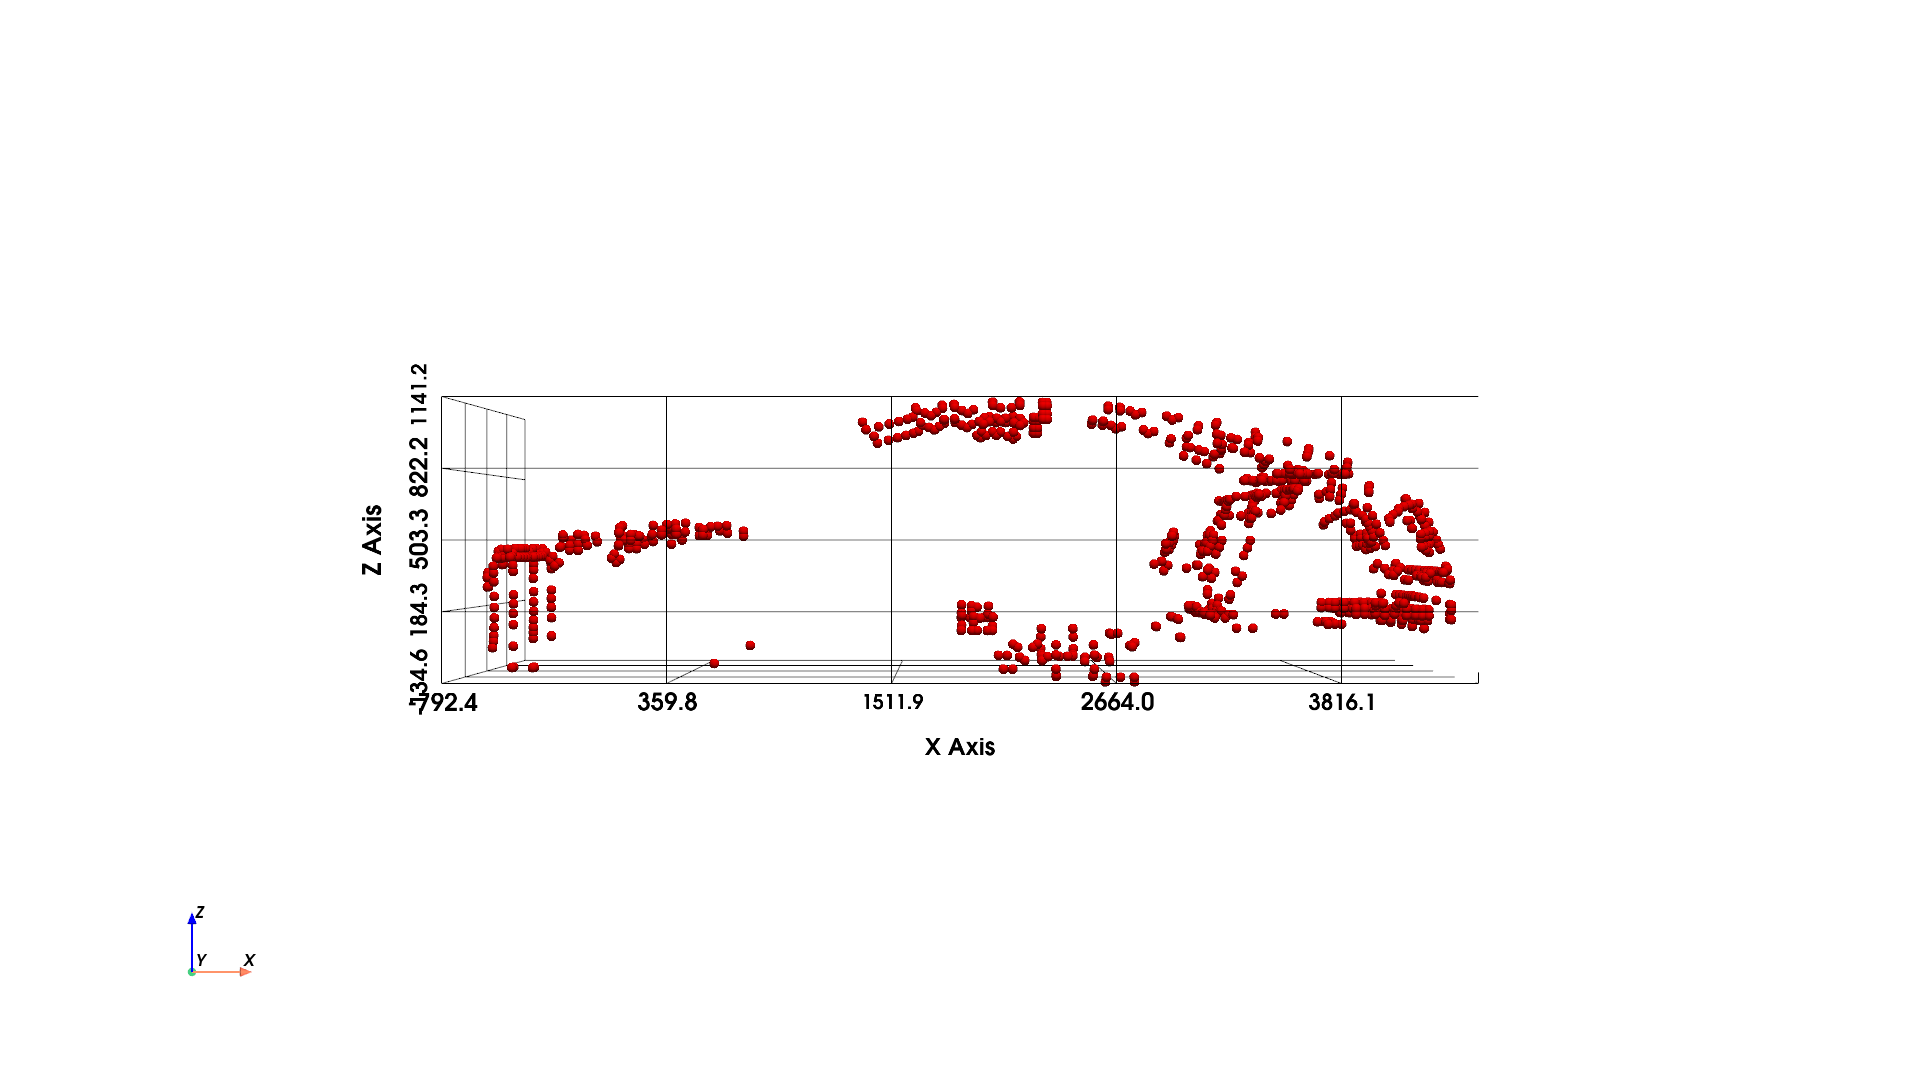

In [44]:
p = pv.Plotter(off_screen=True, window_size=(1920, 1080))

# Light background
p.set_background("white")  # or e.g. '#f0f0f5'

# Add each large body part with smooth shading
for part in large_parts:
    p.add_mesh(
        part,
        color="#A0B0C0",            # steel-ish grey
        smooth_shading=True,
        specular=0.2,
        specular_power=20,
        show_edges=False,
        opacity=1.0,
    )

# Add welds as red spheres
p.add_mesh(
    weld_points,
    color="red",
    point_size=10,
    render_points_as_spheres=True,
)

# Optional helpers
p.add_axes()
p.show_bounds(grid="front")

# Adjust the camera more or less like your CATIA front view
p.camera_position = "xz"  # try "xy", "xz", "yz", or custom positions

# Save screenshot
p.show(screenshot="front_large_parts_welds.png")
